<h1>Q-Learning: From Theory to Implementation.</h1>

In this notebook we introduce the fundamental Q-learning algorithm, one of the core methods in Reinforcement Learning (RL)

In [55]:
import numpy as np
import tqdm
from tqdm import tqdm
import math
import matplotlib.pyplot as plt
from enum import IntEnum
from typing import Tuple, Dict, Any
from dataclasses import dataclass, field
from typing import List

In [56]:
class Action(IntEnum):
    UP = 0
    DOWN = 1
    LEFT = 2
    RIGHT = 3

class GridWorld:
    
    def __init__(self, size: int = 5):
        self.size = size
        self.start_state = (0, 0)
        self.goal_state = (size - 1, size - 1)
        self.agent_pos = self.start_state
        
        self.action_space = list(Action)
        self.n_actions = len(self.action_space)
        self.n_states = size * size

    def to_index(self, row: int, col: int) -> int:
        return row * self.size + col

    def from_index(self, index: int) -> Tuple[int, int]:
        row = index // self.size
        col = index % self.size
        return row, col

    def reset(self) -> Tuple[int, Dict[str, Any]]:
        self.agent_pos = self.start_state
        return self.to_index(*self.agent_pos), {}

    def step(self, action: int) -> Tuple[int, float, bool, bool, Dict[str, Any]]:
        row, col = self.agent_pos

        if action == Action.UP:
            row = max(0, row - 1)
        elif action == Action.DOWN:
            row = min(self.size - 1, row + 1)
        elif action == Action.LEFT:
            col = max(0, col - 1)
        elif action == Action.RIGHT:
            col = min(self.size - 1, col + 1)

        new_pos = (row, col)
        self.agent_pos = new_pos
        
        terminated = (new_pos == self.goal_state)
        reward = 1.0 if terminated else 0.0
        truncated = False
        
        state_index = self.to_index(*new_pos)
        
        info = {"coordinates": new_pos}

        return state_index, reward, terminated, truncated, info

    def render(self):
        grid = np.full((self.size, self.size), ".", dtype=str)
        
        g_row, g_col = self.goal_state
        a_row, a_col = self.agent_pos
        
        grid[g_row, g_col] = "G" # Goal
        grid[a_row, a_col] = "A" # Agent
        
        if self.agent_pos == self.goal_state:
             grid[a_row, a_col] = "✅"

        print(f"\n--- State: {self.agent_pos} ---")
        print("\n".join(" ".join(row) for row in grid))
        print()

In [57]:
env = GridWorld(size=20)

state, _ = env.reset()

print(f"Initial state (index): {state}") 
env.render()

Initial state (index): 0

--- State: (0, 0) ---
A . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . G



In [58]:
def initialize_q_table(n_states: int, n_actions: int) -> np.ndarray:
    q_table = np.zeros((n_states, n_actions), dtype=np.float64)
    return q_table

Q = initialize_q_table(env.n_states, env.n_actions)

print(f"Q-Table shape: {Q.shape}")

Q-Table shape: (400, 4)


In [59]:
n_states = env.n_states
n_actions = env.n_actions

q_table = initialize_q_table(n_states, n_actions)

In [60]:
def epsilon_greedy_policy(q_table: np.ndarray, state_index: int, n_actions: int, epsilon: float) -> int:
    if np.random.rand() < epsilon:
        return np.random.randint(0, n_actions)
    
    state_q_values = q_table[state_index]
    
    noise = np.random.random(n_actions) * 1e-6

    return np.argmax(state_q_values + noise)

In [61]:
def calculate_decay(n_episodes, epsilon_start=1.0, epsilon_end=0.01, finish_at_pct=0.8):
    target_episode = n_episodes * finish_at_pct
    decay = -math.log(epsilon_end / epsilon_start) / target_episode
    return decay

n_episodes = 2000
decay = calculate_decay(n_episodes)

print(f"For {n_episodes} episodes, use decay_rate = {decay:.5f}")

For 2000 episodes, use decay_rate = 0.00288


In [62]:
@dataclass
class QLearningConfig:

    n_training_episodes: int = 2000
    learning_rate: float = 0.2        
    n_eval_episodes: int = 100
    
    max_steps: int = 500                
    gamma: float = 0.99              
    eval_seed: List[int] = field(default_factory=lambda: [42, 123]) 
    
    max_epsilon: float = 1.0         
    min_epsilon: float = 0.05      
    decay_rate: float = 0.00288       

    def __post_init__(self):
        if not (0 <= self.gamma <= 1):
            raise ValueError("Gamma must be between 0 and 1.")
        if not (0 <= self.learning_rate <= 1):
            raise ValueError("Learning rate must be between 0 and 1.")

config = QLearningConfig()

print(f"Configuration loaded. Episodes: {config.n_training_episodes}")

Configuration loaded. Episodes: 2000


In [63]:
def train_agent(env: GridWorld, q_table: np.ndarray, config: QLearningConfig):
    rewards_history = []
    
    pbar = tqdm(range(config.n_training_episodes), desc="Training")
    
    for episode in pbar:
        
        epsilon = config.min_epsilon + (config.max_epsilon - config.min_epsilon) * \
                  np.exp(-config.decay_rate * episode)
        
        state_idx, _ = env.reset()
        
        total_reward = 0
        
        for step in range(config.max_steps):
            action = epsilon_greedy_policy(q_table, state_idx, env.n_actions, epsilon)
            
            new_state_idx, reward, terminated, truncated, info = env.step(action)
            
            current_q = q_table[state_idx, action]
            max_future_q = np.max(q_table[new_state_idx])
            
            new_q = current_q + config.learning_rate * (reward + config.gamma * max_future_q - current_q)
            
            q_table[state_idx, action] = new_q
            
            total_reward += reward
            state_idx = new_state_idx
            
            if terminated or truncated:
                break
        
        rewards_history.append(total_reward)
        
        window_size = 50
        
        if len(rewards_history) >= window_size:
            avg_reward = np.mean(rewards_history[-window_size:])
            
            pbar.set_postfix({
                "Avg Reward": f"{avg_reward:.2f}", 
                "Epsilon": f"{epsilon:.3f}"
            })
            
            if avg_reward >= 0.99:
                print(f"\n🚀 Convergence reached at episode {episode}. Early stopping activated.")
                break

    return q_table, rewards_history

In [64]:
q_table = initialize_q_table(env.n_states, env.n_actions)

trained_q_table, rewards = train_agent(env, q_table, config)

Training:   0%|          | 0/2000 [00:00<?, ?it/s]

Training:  10%|█         | 210/2000 [00:02<00:22, 80.54it/s, Avg Reward=1.00, Epsilon=0.569] 


🚀 Convergence reached at episode 210. Early stopping activated.


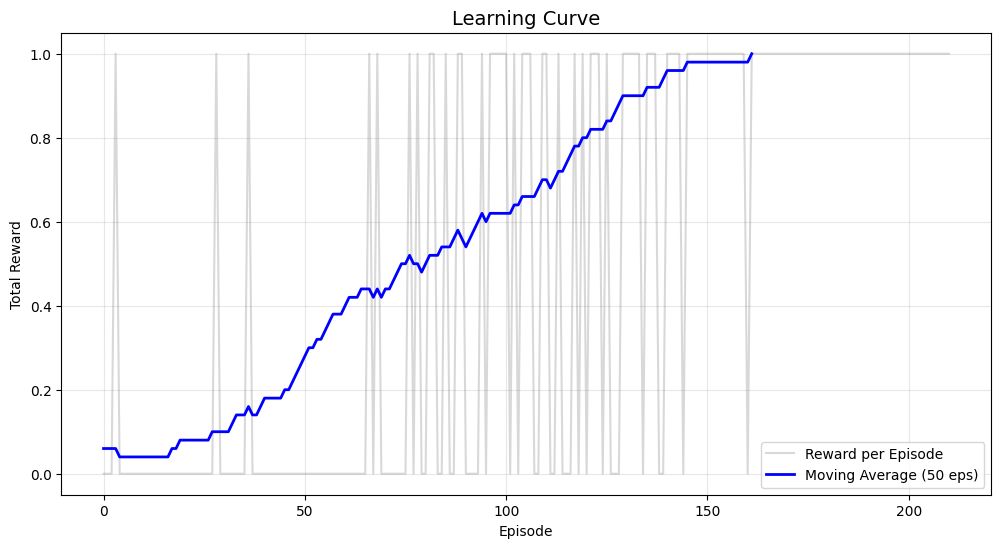

In [65]:
def plot_training_results(rewards: list, window: int = 50):
    moving_average = np.convolve(rewards, np.ones(window)/window, mode='valid')
    
    plt.figure(figsize=(12, 6))
    
    plt.plot(rewards, alpha=0.3, color='gray', label='Reward per Episode')
    plt.plot(moving_average, color='blue', linewidth=2, label=f'Moving Average ({window} eps)')
    
    plt.title("Learning Curve", fontsize=14)
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

plot_training_results(rewards)

In [66]:
np.set_printoptions(suppress=True, precision=9)

trained_q_table

array([[0.000000009, 0.000000011, 0.00000001 , 0.000000012],
       [0.000000014, 0.000000012, 0.00000001 , 0.000000017],
       [0.000000012, 0.000000023, 0.000000011, 0.000000013],
       ...,
       [0.200625175, 0.418244879, 0.097183004, 0.858847868],
       [0.60395498 , 0.55390995 , 0.527285884, 0.977482002],
       [0.         , 0.         , 0.         , 0.         ]])